## Importig Packages

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

## Loading Data

In [23]:
# Get the absolute working directory
current_dir = os.path.abspath(os.getcwd())

# Load the data from the relative path
train_data_path = os.path.join(current_dir, '..', 'data', 'processed', 'train_data2.csv')
train_data = pd.read_csv(train_data_path)

#load test data
test_data_path = os.path.join(current_dir, '..', 'data', 'processed', 'test_data2.csv')
test_data = pd.read_csv(test_data_path)

In [24]:
train_data.head()

,route_id,distance,month,day_of_week_sin,minutes_cos,temperature,precip_mm,humidity,visibility,pressure,...,month_num_cos,temp_rolling_mean,temp_lag_24,humidity_lag_24,temp_range,dew_point,heat_index,humidity_comfort,heat_stress,duration
0,11,2.067080,3,-0.433884,0.190809,1.270038,2.317881,0.109034,0.366571,-2.697698,...,0.581825,-0.691525,0.249037,0.248720,0.520747,2.028411,1.665031,2,0,17.050000
1,10,-0.815606,3,0.433884,0.642788,-0.158288,-0.072688,0.549040,0.366571,-0.244317,...,0.581825,0.756059,0.249037,0.843048,-1.867194,0.333300,-0.245630,2,2,1.283333
2,10,0.169572,4,-0.433884,0.390731,1.841369,-0.414197,-2.090999,0.366571,-0.857662,...,-0.350878,-1.353278,2.112962,-1.783948,1.475924,0.472596,1.874010,1,0,3.066667
3,10,0.169572,7,0.781831,0.777146,1.841369,-0.414197,-2.443004,0.366571,0.982374,...,-1.033664,0.631980,1.491654,-2.440697,-0.912018,0.014672,1.734878,1,0,5.316667
4,10,-0.513131,3,-0.433884,0.292372,-1.300949,0.951842,0.813044,0.366571,-0.244317,...,0.581825,-1.311918,-0.993579,0.843048,-0.434429,-1.126896,-1.152761,2,2,1.616667


In [5]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

In [25]:
dataframe_info(train_data)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_20192\3841810920.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report = pd.concat([report, pd.DataFrame({'Column': [column],


,Column,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
0,route_id,int64,2,"[11, 10]",0,0.0
1,distance,float64,15,"[2.067079877560524, -0.8156058038047639, 0.169...",0,0.0
2,month,int64,7,"[3, 4, 7, 9, 6]",0,0.0
3,day_of_week_sin,float64,5,"[-0.433883739117558, 0.4338837391175582, 0.781...",0,0.0
4,minutes_cos,float64,136,"[0.1908089953765442, 0.6427876096865394, 0.390...",0,0.0
5,temperature,float64,14,"[1.270038416312389, -0.158287751270814, 1.8413...",0,0.0
6,precip_mm,float64,13,"[2.3178812946428864, -0.0726875879013799, -0.4...",0,0.0
7,humidity,float64,39,"[0.1090337340534468, 0.5490403095762327, -2.09...",0,0.0
8,visibility,float64,5,"[0.3665712089052488, -3.077969424494908, -0.06...",0,0.0
9,pressure,float64,10,"[-2.697698401595672, -0.2443171031453517, -0.8...",0,0.0


## Data Splitting

In [26]:
X_train = train_data.drop('duration', axis=1)
y_train = train_data['duration']
X_test = test_data.drop('duration', axis=1)
y_test = test_data['duration']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((672, 27), (672,), (169, 27), (169,))

## Feature Selection

In [27]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, f_regression
from sklearn.linear_model import LassoLarsCV, LassoLarsIC

# Total number of features in the original dataset
all_cols = X_train.columns.to_list()
print(f"All features: {all_cols}\n")

# LassoLarsIC for feature selection
print("LassoLarsIC Feature Selection")
llarsic_selection = SelectFromModel(LassoLarsIC(criterion='aic', max_iter=1000, eps=0.001), max_features=12)
llarsic_selection.fit(X_train, y_train)
llarsic_cols = X_train.columns[llarsic_selection.get_support()].tolist()
print(f"Number of selected features: {len(llarsic_cols)}")
print(f"Selected features: {llarsic_cols}\n")

# SelectKBest with mutual_info_regression for feature selection
print("SelectKBest with mutual_info_regression Feature Selection")
mic_selection = SelectKBest(mutual_info_regression, k=12)
mic_selection.fit(X_train, y_train)
mic_cols = X_train.columns[mic_selection.get_support()].tolist()
print(f"Number of selected features: {len(mic_cols)}")
print(f"Selected features: {mic_cols}\n")

print("SelectKBest with f_regression Feature Selection")
f_regression_selection = SelectKBest(score_func=f_regression, k=12)
f_regression_selection.fit_transform(X_train, y_train) 
f_regression_cols = X_train.columns[f_regression_selection.get_support()].to_list()
print(f"Number of selected features: {len(f_regression_cols)}")
print(f"Selected features: {f_regression_cols}\n")


All features: ['route_id', 'distance', 'month', 'day_of_week_sin', 'minutes_cos', 'temperature', 'precip_mm', 'humidity', 'visibility', 'pressure', 'cloud_cover', 'wind_speed', 'hour', 'day', 'month_num', 'hour_sin', 'hour_cos', 'month_num_sin', 'month_num_cos', 'temp_rolling_mean', 'temp_lag_24', 'humidity_lag_24', 'temp_range', 'dew_point', 'heat_index', 'humidity_comfort', 'heat_stress']

LassoLarsIC Feature Selection
Number of selected features: 11
Selected features: ['route_id', 'distance', 'temperature', 'precip_mm', 'humidity', 'visibility', 'cloud_cover', 'wind_speed', 'hour', 'month_num_cos', 'temp_lag_24']

SelectKBest with mutual_info_regression Feature Selection
Number of selected features: 12
Selected features: ['route_id', 'distance', 'month', 'day_of_week_sin', 'minutes_cos', 'visibility', 'wind_speed', 'hour', 'month_num', 'month_num_sin', 'month_num_cos', 'temp_range']

SelectKBest with f_regression Feature Selection
Number of selected features: 12
Selected features: [

## Model Evaluation 1

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt

def evaluate_regression_mdl(fitted_model, X_train, X_test, y_train, y_test):
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    
    return {
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'mae_train': mean_absolute_error(y_train, y_train_pred),
        'mae_test': mean_absolute_error(y_test, y_test_pred),
        'r2_train': r2_score(y_train, y_train_pred),
        'r2_test': r2_score(y_test, y_test_pred)
    }

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0)),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=42),
    'XGBoost': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'CatBoost': CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=False)
}

feature_selection_methods = {
    'none': None,
    'f_regression': f_regression_cols,
    'mutual_info': mic_cols,
    'llarsic' : llarsic_cols
}

results = []

for model_name, model in models.items():
    for fs_method, selected_features in feature_selection_methods.items():
        print(f"Training {model_name} with {fs_method} feature selection...")
        
        if selected_features is None:
            X_train_fs = X_train
            X_test_fs = X_test
        else:
            X_train_fs = X_train[selected_features]
            X_test_fs = X_test[selected_features]
        
        # Fit model
        model.fit(X_train_fs, y_train)
        
        # Evaluate model
        eval_metrics = evaluate_regression_mdl(model, X_train_fs, X_test_fs, y_train, y_test)
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_fs, y_train, cv=5, scoring='r2')
        
        # Calculate percentage differences
        rmse_diff_pct = ((eval_metrics['rmse_test'] - eval_metrics['rmse_train']) / eval_metrics['rmse_train']) * 100
        mae_diff_pct = ((eval_metrics['mae_test'] - eval_metrics['mae_train']) / eval_metrics['mae_train']) * 100
        r2_diff_pct = ((eval_metrics['r2_train'] - eval_metrics['r2_test']) / eval_metrics['r2_train']) * 100
        
        results.append({
            'model': f"{model_name}_{fs_method}",
            'fs_method': fs_method,
            'rmse_train': eval_metrics['rmse_train'],
            'rmse_test': eval_metrics['rmse_test'],
            'rmse_diff_pct': rmse_diff_pct,
            'mae_train': eval_metrics['mae_train'],
            'mae_test': eval_metrics['mae_test'],
            'mae_diff_pct': mae_diff_pct,
            'r2_train': eval_metrics['r2_train'],
            'r2_test': eval_metrics['r2_test'],
            'r2_diff_pct': r2_diff_pct,
            'num_feat': X_train_fs.shape[1],
            'cv_r2_mean': cv_scores.mean()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by Test R2 score
results_df = results_df.sort_values('cv_r2_mean', ascending=False).reset_index(drop=True)

# Display results
print("\nModel Comparison Results:")
print(results_df)

# Save results to CSV
# results_df.to_csv('model_basicfs_comparison.csv', index=False)

Training Linear Regression with none feature selection...
Training Linear Regression with f_regression feature selection...
Training Linear Regression with mutual_info feature selection...
Training Linear Regression with llarsic feature selection...
Training Ridge with none feature selection...
Training Ridge with f_regression feature selection...
Training Ridge with mutual_info feature selection...
Training Ridge with llarsic feature selection...
Training Polynomial Regression with none feature selection...
Training Polynomial Regression with f_regression feature selection...
Training Polynomial Regression with mutual_info feature selection...
Training Polynomial Regression with llarsic feature selection...
Training Decision Tree with none feature selection...
Training Decision Tree with f_regression feature selection...
Training Decision Tree with mutual_info feature selection...
Training Decision Tree with llarsic feature selection...
Training Random Forest with none feature selecti

In [29]:
results_df.set_index('model').style.\
background_gradient(cmap='bone_r', subset=['mae_train', 'mae_test']).\
background_gradient(cmap='viridis', subset=['r2_train', 'r2_test']).\
background_gradient(cmap='magma', subset=['cv_r2_mean']).\
background_gradient(cmap='gist_heat',  low=0.5, high=3, subset=['mae_diff_pct', 'r2_diff_pct'])

,fs_method,rmse_train,rmse_test,rmse_diff_pct,mae_train,mae_test,mae_diff_pct,r2_train,r2_test,r2_diff_pct,num_feat,cv_r2_mean
model,,,,,,,,,,,,
Random Forest_f_regression,f_regression,1.733638,2.058007,18.710270,1.005725,1.221408,21.445538,0.834691,0.794296,4.839502,12,0.760881
Random Forest_llarsic,llarsic,1.737931,2.233156,28.495119,1.018858,1.291205,26.730627,0.833872,0.757793,9.123540,11,0.758368
Random Forest_none,none,1.652217,2.065996,25.043865,0.946157,1.214640,28.376152,0.849854,0.792696,6.725639,27,0.757595
Random Forest_mutual_info,mutual_info,1.747722,2.033620,16.358316,0.982293,1.184357,20.570602,0.831994,0.799142,3.948577,12,0.753710
CatBoost_none,none,1.623612,2.084549,28.389600,1.004996,1.293309,28.687930,0.855008,0.788956,7.725317,27,0.740078
CatBoost_mutual_info,mutual_info,1.695722,2.246924,32.505466,1.007543,1.300643,29.090642,0.841843,0.754797,10.339918,12,0.733881
CatBoost_f_regression,f_regression,1.734417,2.119742,22.216400,1.031519,1.266512,22.781251,0.834543,0.781770,6.323551,12,0.733457
CatBoost_llarsic,llarsic,1.737732,2.313115,33.111139,1.049071,1.366200,30.229498,0.833909,0.740138,11.244832,11,0.731961
Decision Tree_f_regression,f_regression,1.796702,2.305783,28.334173,1.047689,1.373944,31.140402,0.822446,0.741783,9.807701,12,0.727354


Features: 2, CV R2 Score: 0.7205 ± 0.1118
Features: 4, CV R2 Score: 0.7074 ± 0.1359
Features: 6, CV R2 Score: 0.7216 ± 0.1283
Features: 8, CV R2 Score: 0.7297 ± 0.1059
Features: 10, CV R2 Score: 0.7343 ± 0.1062
Features: 12, CV R2 Score: 0.7335 ± 0.1045
Features: 14, CV R2 Score: 0.7233 ± 0.1173
Features: 16, CV R2 Score: 0.7426 ± 0.1097
Features: 18, CV R2 Score: 0.7403 ± 0.1095
Features: 20, CV R2 Score: 0.7403 ± 0.1069
Features: 22, CV R2 Score: 0.7397 ± 0.1251
Features: 24, CV R2 Score: 0.7323 ± 0.1228
Features: 26, CV R2 Score: 0.7326 ± 0.1383


e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.warn(


Features: 28, CV R2 Score: 0.7401 ± 0.1239


e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.warn(


Features: 30, CV R2 Score: 0.7401 ± 0.1239


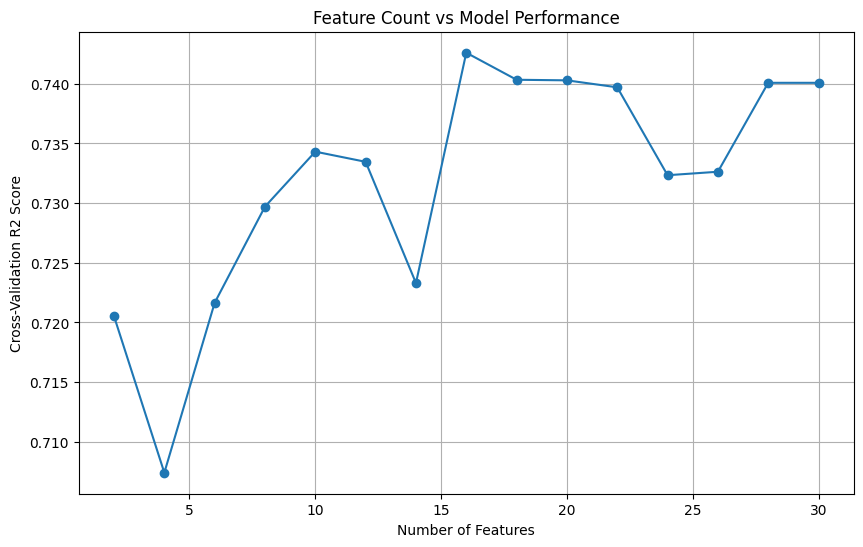


Optimal number of features: 16

Best features: ['route_id', 'distance', 'day_of_week_sin', 'minutes_cos', 'precip_mm', 'humidity', 'visibility', 'pressure', 'cloud_cover', 'hour', 'hour_sin', 'hour_cos', 'temp_lag_24', 'humidity_lag_24', 'dew_point', 'humidity_comfort']


In [30]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_feature_count(X_train, y_train, feature_selector, max_features=30, step=2):
    feature_counts = range(2, max_features + 1, step)
    cv_scores = []
    
    for n_features in feature_counts:
        # Select top n features
        selector = SelectKBest(feature_selector, k=n_features)
        X_selected = selector.fit_transform(X_train, y_train)
        
        # Initialize and evaluate CatBoost
        model = CatBoostRegressor(
            iterations=100,
            depth=3,
            learning_rate=0.1,
            loss_function='RMSE',
            verbose=False
        )
        
        # Perform cross-validation
        scores = cross_val_score(
            model, 
            X_selected, 
            y_train, 
            cv=5, 
            scoring='r2'
        )
        
        cv_scores.append(scores.mean())
        print(f"Features: {n_features}, CV R2 Score: {scores.mean():.4f} ± {scores.std():.4f}")
    
    return feature_counts, cv_scores

# Evaluate using f_regression
feature_counts, cv_scores = evaluate_feature_count(X_train, y_train, f_regression)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation R2 Score')
plt.title('Feature Count vs Model Performance')
plt.grid(True)
plt.show()

# Find optimal number of features
optimal_features = feature_counts[np.argmax(cv_scores)]
print(f"\nOptimal number of features: {optimal_features}")

# Get the names of the best features
selector = SelectKBest(f_regression, k=optimal_features)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()].tolist()
print(f"\nBest features: {selected_features}")


Analyzing 2 features...

Analyzing 4 features...

Analyzing 6 features...

Analyzing 8 features...

Analyzing 10 features...

Analyzing 12 features...

Analyzing 14 features...

Analyzing 16 features...

Analyzing 18 features...

Analyzing 20 features...

Analyzing 22 features...

Analyzing 24 features...

Analyzing 26 features...

Analyzing 28 features...


e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=28 is greater than n_features=27. All the features will be returned.
  warnings.w


Analyzing 30 features...


e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.warn(
e:\bus-schedule-app\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=30 is greater than n_features=27. All the features will be returned.
  warnings.w


Optimal features for f_regression: 10
Best R² score: 0.7414 ± 0.0904
95% CI: [0.7059, 0.7768]

Optimal features for mutual_info: 16
Best R² score: 0.7409 ± 0.0972
95% CI: [0.7028, 0.7790]

Selected features: ['route_id', 'distance', 'minutes_cos', 'precip_mm', 'humidity', 'visibility', 'pressure', 'hour', 'hour_sin', 'hour_cos']


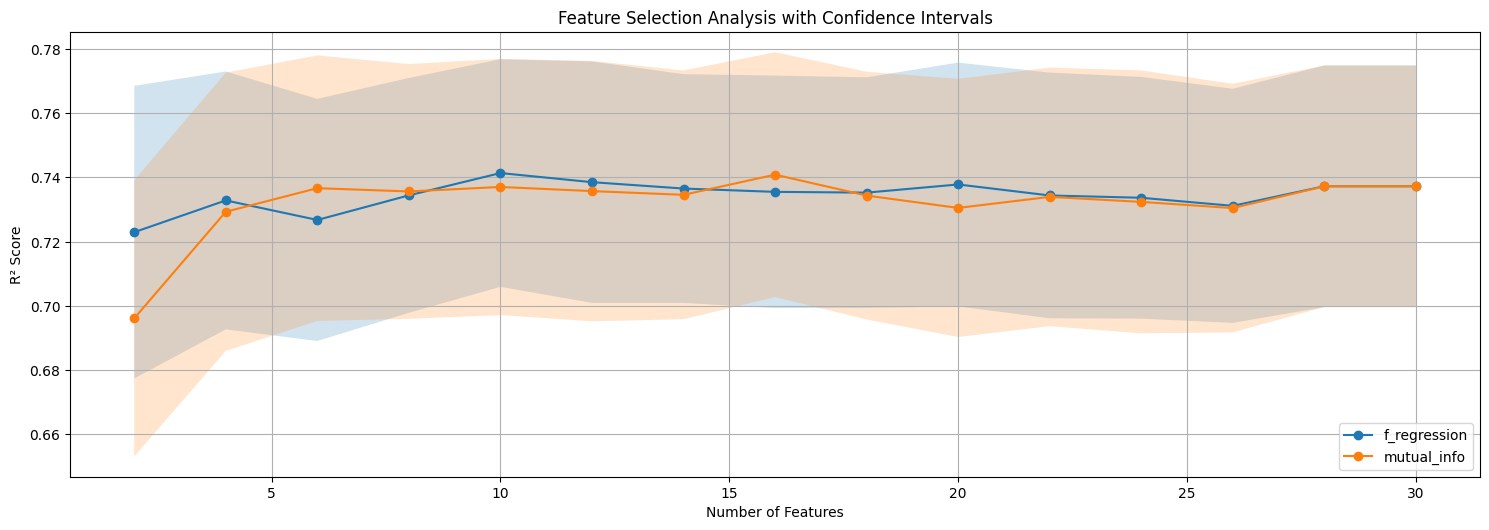

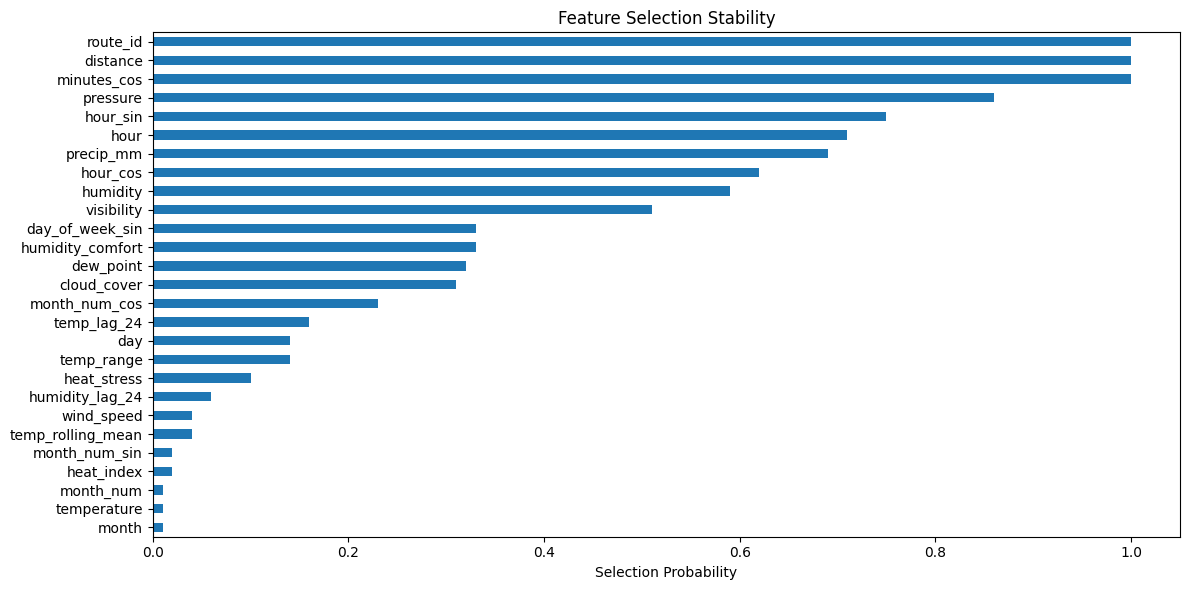

In [31]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error  # Updated import
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def feature_selection_analysis(X_train, y_train, max_features=27, n_trials=5, cv_folds=5):
    feature_range = range(2, max_features + 1, 2)
    results = {
        'f_regression': [],
        'mutual_info': []
    }
    
    # Define scorers - Updated to use root_mean_squared_error
    scorers = {
        'r2': make_scorer(r2_score),
        'rmse': make_scorer(root_mean_squared_error)  # Updated scorer
    }
    
    # Rest of the function remains the same
    for n_features in feature_range:
        print(f"\nAnalyzing {n_features} features...")
        
        trial_scores = {
            'f_regression': {'r2': [], 'rmse': []},
            'mutual_info': {'r2': [], 'rmse': []}
        }
        
        for trial in range(n_trials):
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42+trial)
            
            for selector_name, selector_func in [
                ('f_regression', f_regression),
                ('mutual_info', mutual_info_regression)
            ]:
                selector = SelectKBest(selector_func, k=n_features)
                X_selected = selector.fit_transform(X_train, y_train)
                
                model = CatBoostRegressor(
                    iterations=100,
                    depth=3,
                    learning_rate=0.1,
                    loss_function='RMSE',
                    verbose=False,
                    random_state=42+trial
                )
                
                for scorer_name, scorer in scorers.items():
                    scores = cross_val_score(
                        model, X_selected, y_train,
                        cv=kf, scoring=scorer
                    )
                    trial_scores[selector_name][scorer_name].extend(scores)
        
        for selector_name in ['f_regression', 'mutual_info']:
            mean_r2 = np.mean(trial_scores[selector_name]['r2'])
            std_r2 = np.std(trial_scores[selector_name]['r2'])
            mean_rmse = np.mean(trial_scores[selector_name]['rmse'])
            std_rmse = np.std(trial_scores[selector_name]['rmse'])
            
            results[selector_name].append({
                'n_features': n_features,
                'mean_r2': mean_r2,
                'std_r2': std_r2,
                'mean_rmse': mean_rmse,
                'std_rmse': std_rmse,
                'ci_lower_r2': mean_r2 - 1.96 * std_r2 / np.sqrt(n_trials * cv_folds),
                'ci_upper_r2': mean_r2 + 1.96 * std_r2 / np.sqrt(n_trials * cv_folds)
            })
    
    return results

# Run analysis
results = feature_selection_analysis(X_train, y_train)

# Plotting
plt.figure(figsize=(15, 10))

# Plot R2 scores
plt.subplot(2, 1, 1)
for method in ['f_regression', 'mutual_info']:
    n_features = [r['n_features'] for r in results[method]]
    mean_r2 = [r['mean_r2'] for r in results[method]]
    ci_lower = [r['ci_lower_r2'] for r in results[method]]
    ci_upper = [r['ci_upper_r2'] for r in results[method]]
    
    plt.plot(n_features, mean_r2, label=f'{method}', marker='o')
    plt.fill_between(n_features, ci_lower, ci_upper, alpha=0.2)

plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('Feature Selection Analysis with Confidence Intervals')
plt.grid(True)
plt.legend()

# Find optimal number of features
optimal_features = {}
for method in ['f_regression', 'mutual_info']:
    max_r2_idx = np.argmax([r['mean_r2'] for r in results[method]])
    optimal_features[method] = results[method][max_r2_idx]['n_features']
    
    # Statistical significance test
    max_score = results[method][max_r2_idx]['mean_r2']
    max_std = results[method][max_r2_idx]['std_r2']
    
    print(f"\nOptimal features for {method}: {optimal_features[method]}")
    print(f"Best R² score: {max_score:.4f} ± {max_std:.4f}")
    print(f"95% CI: [{results[method][max_r2_idx]['ci_lower_r2']:.4f}, "
          f"{results[method][max_r2_idx]['ci_upper_r2']:.4f}]")

# Get final feature set
final_selector = SelectKBest(f_regression, k=optimal_features['f_regression'])
final_selector.fit(X_train, y_train)
selected_features = X_train.columns[final_selector.get_support()].tolist()
print("\nSelected features:", selected_features)

plt.tight_layout()
plt.show()

# Perform statistical test for feature importance stability
def feature_importance_stability(X_train, y_train, n_features, n_bootstrap=100):
    feature_counts = np.zeros(X_train.shape[1])
    
    for i in range(n_bootstrap):
        # Bootstrap sampling
        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_boot = X_train.iloc[indices]
        y_boot = y_train.iloc[indices]
        
        # Feature selection
        selector = SelectKBest(f_regression, k=n_features)
        selector.fit(X_boot, y_boot)
        feature_counts += selector.get_support()
    
    # Calculate selection probability for each feature
    selection_prob = feature_counts / n_bootstrap
    
    return pd.Series(selection_prob, index=X_train.columns)

stability_scores = feature_importance_stability(
    X_train, y_train, 
    optimal_features['f_regression']
)

# Plot feature stability
plt.figure(figsize=(12, 6))
stability_scores.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Selection Stability')
plt.xlabel('Selection Probability')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],               # Fewer estimators for smaller datasets
    'max_depth': [None, 5, 10, 20],              # Limit the depth of the trees
    'min_samples_split': [5, 7, 10, 12],             # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples to be at a leaf node
    'max_features': ['sqrt', 'log2']     # Number of features to consider at each split
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV to the data
grid_search.fit(X_train[f_regression_cols], y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best parameters found: ", best_params)

# Evaluate the best model on the test set
y_train_pred = best_rf.predict(X_train[f_regression_cols])
y_test_pred = best_rf.predict(X_test[f_regression_cols])

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train R2: ", r2_score(y_train, y_train_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

# Extract feature importances
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train[f_regression_cols].columns).sort_values(ascending=False)

# Get the list of selected features based on importance
rf_selected_features = feature_importances.index.tolist()

print("Selected Features: ", rf_selected_features)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 50}
Train RMSE:  1.853196729825306
Test RMSE:  2.122897301203026
Train R2:  0.811104222285802
Test R2:  0.7811197075514581
Selected Features:  ['distance', 'minutes_cos', 'route_id', 'humidity', 'hour', 'humidity_cleaned', 'pressure', 'hour_cos', 'hour_sin', 'precip_mm', 'visibility_cleaned', 'visibility']


e:\bus-schedule-app\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
